In [31]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import HiveContext
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('rus_trolls').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '8g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.driver.port', '34575'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.executor.instances', '32'),
 ('spark.driver.memory', '4g'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://md01.rcc.local:8088/proxy/application_1547750003855_6130,http://md02.rcc.local:8088/proxy/application_1547750003855_6130'),
 ('spark.ui.killEnabled', 'true'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.eventLog.dir', 'hdfs://nameservice1/user/spark/applicationHistory'),
 ('spark.yarn.am.extraLibraryPath',
  '/opt/cloudera/parcels/CDH-6.1.0-1.cdh6.1.0.p0.770702/lib/hadoop/lib/native'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.exe

In [6]:
sc = spark.sparkContext
hc = HiveContext(sc)

In [7]:
hive_context = HiveContext(sc)
data = hive_context.table("tywang.rus_tweets")
data.show()

+------------------+--------------------+--------------------+--------------------+----------------------+------------------------+--------------------+--------------+---------------+---------------------+----------------+--------------+--------------------+----------------+------------------+-------------------+------------------+--------------------+----------+--------------+------------------+--------+---------+-----------+-----------+----------+-------------+--------------------+--------------------+-------------+------------+
|           tweetid|              userid|   user_display_name|    user_screen_name|user_reported_location|user_profile_description|    user_profile_url|follower_count|following_count|account_creation_date|account_language|tweet_language|          tweet_text|      tweet_time| tweet_client_name|in_reply_to_tweetid|in_reply_to_userid|quoted_tweet_tweetid|is_retweet|retweet_userid|   retweet_tweetid|latitude|longitude|quote_count|reply_count|like_count|retweet_co

In [9]:
from pyspark.sql.types import *

In [10]:
data = data.withColumn('tweet_time', F.to_timestamp(data.tweet_time, "yyyy-MM-dd HH:mm"))

In [11]:
data.dtypes

[('tweetid', 'bigint'),
 ('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('follower_count', 'int'),
 ('following_count', 'int'),
 ('account_creation_date', 'timestamp'),
 ('account_language', 'string'),
 ('tweet_language', 'string'),
 ('tweet_text', 'string'),
 ('tweet_time', 'timestamp'),
 ('tweet_client_name', 'string'),
 ('in_reply_to_tweetid', 'bigint'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'bigint'),
 ('is_retweet', 'boolean'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'bigint'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('quote_count', 'double'),
 ('reply_count', 'double'),
 ('like_count', 'double'),
 ('retweet_count', 'double'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [13]:
data.select('tweet_time').show(10)

+-------------------+
|         tweet_time|
+-------------------+
|2015-01-03 10:33:00|
|2014-07-19 01:27:00|
|2014-11-03 17:21:00|
|2014-08-04 11:54:00|
|2014-10-14 06:32:00|
|2014-11-11 20:51:00|
|2015-04-30 19:31:00|
|2014-09-24 16:06:00|
|2014-10-23 11:04:00|
|2016-11-01 14:34:00|
+-------------------+
only showing top 10 rows



In [17]:
# Filter out non-English tweets and count null

from pyspark.sql.functions import isnan, when, count, col
df_eng = data.filter(data.tweet_language == 'en')
null_count = df_eng.select([count(when(df_eng[c].isNull(), c)).alias(c) for c in df_eng.columns]).toPandas()

In [18]:
total_rows = df_eng.count()
null_count = null_count.transpose().sort_values(by=[0], ascending=False)
null_count = null_count.assign(prop_missing = null_count[0] / total_rows)
null_count.reset_index(inplace=True)
null_count.columns = ['column', 'count_missing', 'prop_missing']

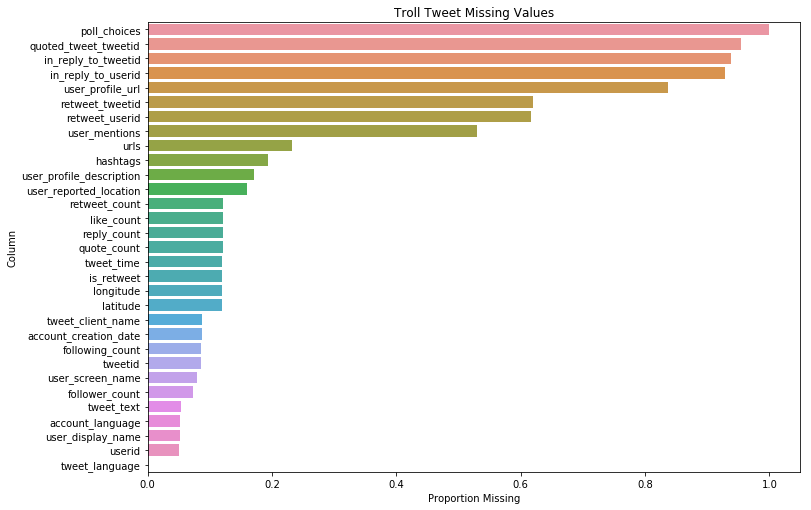

In [19]:
import seaborn as sns

sns.set_palette("Spectral")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='prop_missing', y="column", data=null_count)
ax.set_title("Troll Tweet Missing Values")
ax.set_xlabel("Proportion Missing")
ax.set_ylabel("Column")
plt.show()

In [20]:
# Drop tweets with missing features in the various counts

subset_cols = ['retweet_count', 'like_count', 'reply_count', 'quote_count']
df_eng_dropped = df_eng.dropna(subset=subset_cols)

In [21]:
total_rows_dropped = df_eng_dropped.count()

3618222

In [24]:
total_rows_dropped = df_eng_dropped.count()
null_count_dropped = df_eng_dropped.select([count(when(df_eng_dropped[c].isNull(), c)).alias(c) for c in df_eng_dropped.columns]).toPandas()
total_rows = df_eng_dropped.count()
null_count_dropped = null_count_dropped.transpose().sort_values(by=[0], ascending=False)
null_count_dropped = null_count_dropped.assign(prop_missing = null_count_dropped[0] / total_rows_dropped)
null_count_dropped.reset_index(inplace=True)
null_count_dropped.columns = ['column', 'count_missing', 'prop_missing']

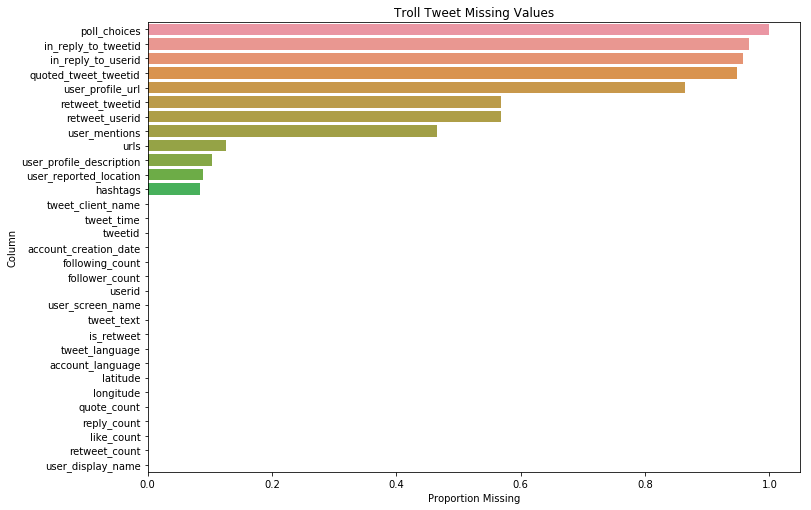

In [25]:
sns.set_palette("Spectral")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='prop_missing', y="column", data=null_count_dropped)
ax.set_title("Troll Tweet Missing Values")
ax.set_xlabel("Proportion Missing")
ax.set_ylabel("Column")
plt.show()

In [26]:
df_timeSeries = df_eng_dropped.withColumn('tweet_time', F.date_format('tweet_time', 'MM/dd/yyy'))

twtCount_time = df_timeSeries.groupBy('tweet_time', 'tweet_language').count().orderBy('count', ascending=False).toPandas()

In [32]:
twtCount_time['tweet_time'] = pd.to_datetime(twtCount_time.tweet_time)

In [35]:
twtCount_time['year'] = twtCount_time.tweet_time.apply(lambda x: x.year)
twtCount_time['month'] = twtCount_time.tweet_time.apply(lambda x: x.month)
twtCount_time['day'] = twtCount_time.tweet_time.apply(lambda x: x.day)

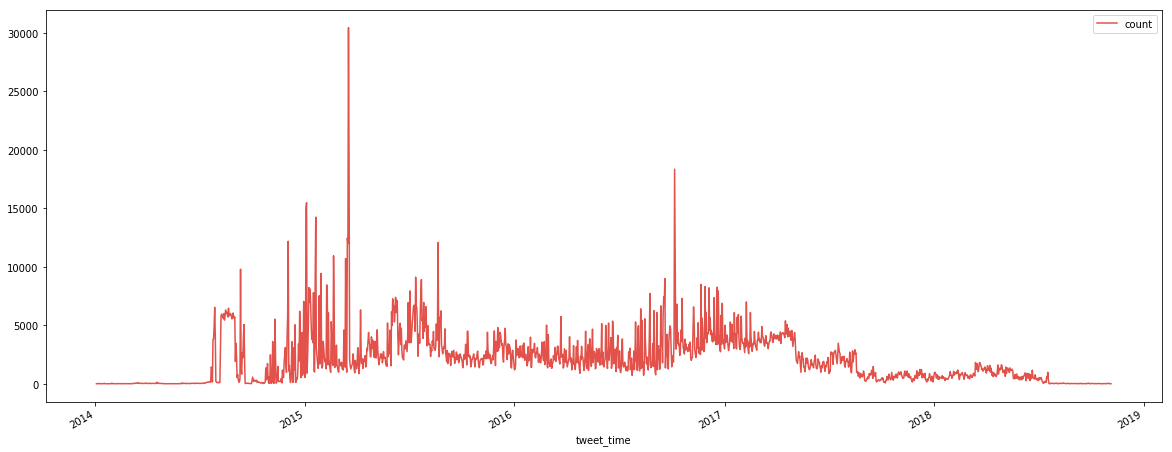

In [36]:
twtCount_time[twtCount_time.year >= 2014].set_index('tweet_time').plot(figsize = (20, 8), y='count', style='-')

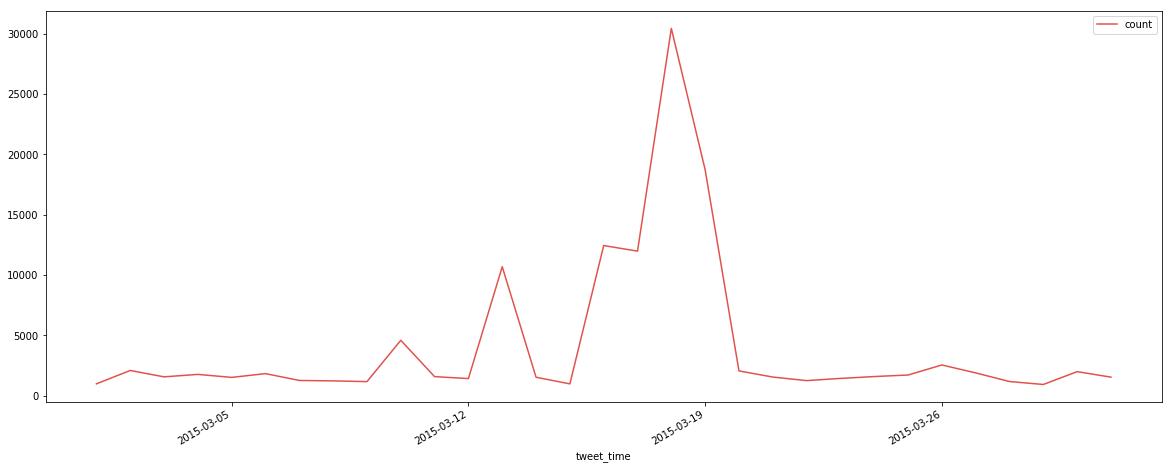

In [39]:
twtCount_time[(twtCount_time.year == 2015) & (twtCount_time.month == 3)].set_index('tweet_time').plot(figsize = (20, 8), y='count', style='-')

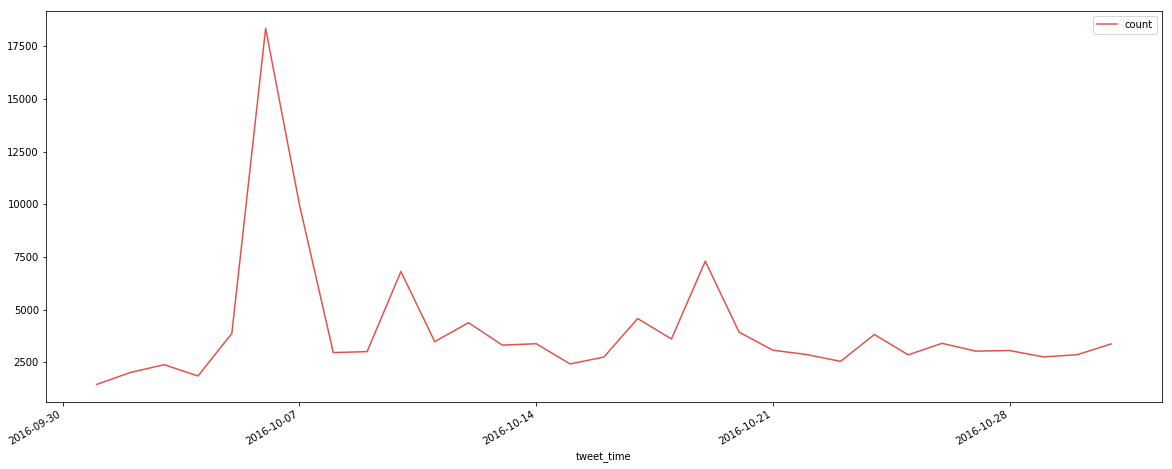

In [38]:
twtCount_time[(twtCount_time.year == 2016) & (twtCount_time.month == 10)].set_index('tweet_time').plot(figsize = (20, 8), y='count', style='-')

In [47]:
candidacy = df_eng_dropped.filter(F.col("tweet_time") > F.unix_timestamp(F.lit('2015-03-18 00:00:00')).cast('timestamp')).filter(F.col("tweet_time") < F.unix_timestamp(F.lit('2015-03-19 00:00:00')).cast('timestamp'))

In [48]:
candidacy.select('tweet_text').show(10)

+--------------------+
|          tweet_text|
+--------------------+
|I love this one! ...|
|I just want to st...|
|And how does the ...|
|Your attitude is ...|
|I'd better stay h...|
|I’m too fat!!! 😭...|
|I just wish you w...|
|loool dat ass-swi...|
|wow, the guys are...|
|As a kid I killed...|
+--------------------+
only showing top 10 rows

